In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [ ]:
# Segmentation Dataset Summary

import os

# Define base path to segmentation model folders
seg_base = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model"

# Paths for training and validation sets
train_img_dir = os.path.join(seg_base, "Train", "Images")
train_lbl_dir = os.path.join(seg_base, "Train", "Labels")
val_img_dir = os.path.join(seg_base, "Validation", "Images")
val_lbl_dir = os.path.join(seg_base, "Validation", "Labels")

# Count files in each folder
train_images_count = len(os.listdir(train_img_dir))
train_labels_count = len(os.listdir(train_lbl_dir))
val_images_count = len(os.listdir(val_img_dir))
val_labels_count = len(os.listdir(val_lbl_dir))

# Print summary
print("Segmentation Dataset Summary")
print("Training Set:")
print(f"  - {train_images_count} images")
print(f"  - {train_labels_count} labels")
print("Validation Set:")
print(f"  - {val_images_count} images")
print(f"  - {val_labels_count} labels")
print("Each image has a corresponding label.")


Segmentation Dataset Summary
Training Set:
  - 1760 images
  - 1760 labels
Validation Set:
  - 440 images
  - 440 labels
Each image has a corresponding label.


# ***Segmentation Phase using UNet++ Light Model***

In [ ]:
import os
# Base directory for segmentation training models
base_dir = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model"

# Name of the new model directory (custom lighter version of UNet++)
model_name = "UNetPlusPlus_Light"

# Full path to the new model directory and its subfolders
model_dir = os.path.join(base_dir, model_name)
pred_dir = os.path.join(model_dir, "Predicted_Labels")

# Create the new model directory and the prediction output folder
os.makedirs(model_dir, exist_ok=True)
os.makedirs(pred_dir, exist_ok=True)

print(f"Custom UNet++ model folder created at: {model_dir}")


Custom UNet++ model folder created at: /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light


# ***Loss Function Definition for Multiclass Segmentation Training***

# ***Corrected By Dr.Basma***


In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf

def dice_coefficient_multiclass(y_true, y_pred, smooth=1e-6):
    """
    Vectorized Dice coefficient for multiclass segmentation.
    Assumes y_true and y_pred are both one-hot encoded with shape (..., num_classes).
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true * y_pred, axis=[0, 1, 2, 3])
    denominator = K.sum(y_true + y_pred, axis=[0, 1, 2, 3])

    dice = (2. * intersection + smooth) / (denominator + smooth)
    return K.mean(dice)

def dice_loss_multiclass(y_true, y_pred):
    return 1.0 - dice_coefficient_multiclass(y_true, y_pred)


In [ ]:
 from tensorflow.keras.utils import Sequence
class NiiDataGenerator(Sequence):
    def __init__(self, image_dir, label_dir, batch_size=2, dim=(96, 128, 128), num_classes=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.dim = dim
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith(".nii.gz")])
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_files)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __data_generation(self, batch_files):
        X = np.empty((self.batch_size, *self.dim, 1), dtype=np.float32)
        y = np.empty((self.batch_size, *self.dim, self.num_classes), dtype=np.float32)

        for i, file in enumerate(batch_files):
            img_path = os.path.join(self.image_dir, file)
            label_path = os.path.join(self.label_dir, file.replace(".nii.gz", "_gt.nii.gz"))
            img = nib.load(img_path).get_fdata()
            label = nib.load(label_path).get_fdata()
            mean, std = np.mean(img), np.std(img)
            img = (img - mean) / std if std > 0 else np.zeros_like(img)
            X[i, ..., 0] = img
            y[i] = tf.one_hot(label.astype(np.uint8), depth=self.num_classes)

        return X, y

In [ ]:
# UNet++ Light Model

def conv_block_light(input_tensor, filters, name_prefix):
    x = layers.Conv3D(filters, (3, 3, 3), padding='same', name=f'{name_prefix}_conv1')(input_tensor)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn1')(x)
    x = layers.ReLU(name=f'{name_prefix}_relu1')(x)
    x = layers.Conv3D(filters, (3, 3, 3), padding='same', name=f'{name_prefix}_conv2')(x)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn2')(x)
    x = layers.ReLU(name=f'{name_prefix}_relu2')(x)
    return x
from tensorflow.keras import layers, models
def unetpp_light_3d(input_shape=(96, 128, 128, 1), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    x0_0 = conv_block_light(inputs, 16, "x0_0")
    x1_0 = conv_block_light(layers.MaxPooling3D((2, 2, 2))(x0_0), 32, "x1_0")
    x2_0 = conv_block_light(layers.MaxPooling3D((2, 2, 2))(x1_0), 64, "x2_0")
    x3_0 = conv_block_light(layers.MaxPooling3D((2, 2, 2))(x2_0), 128, "x3_0")
    x4_0 = conv_block_light(layers.MaxPooling3D((2, 2, 2))(x3_0), 256, "x4_0")
    x3_1 = conv_block_light(layers.Concatenate()([x3_0, layers.UpSampling3D((2, 2, 2))(x4_0)]), 128, "x3_1")
    x2_2 = conv_block_light(layers.Concatenate()([x2_0, layers.UpSampling3D((2, 2, 2))(x3_1)]), 64, "x2_2")
    x1_3 = conv_block_light(layers.Concatenate()([x1_0, layers.UpSampling3D((2, 2, 2))(x2_2)]), 32, "x1_3")
    x0_4 = conv_block_light(layers.Concatenate()([x0_0, layers.UpSampling3D((2, 2, 2))(x1_3)]), 16, "x0_4")
    outputs = layers.Conv3D(num_classes, (1, 1, 1), activation='softmax', name='final_conv')(x0_4)
    return models.Model(inputs, outputs, name="UNetPlusPlus_Light_3D")


In [ ]:
import tensorflow as tf

#  Model Compilation
input_shape = (96, 128, 128, 1)
num_classes = 4
model = unetpp_light_3d(input_shape=input_shape, num_classes=num_classes)
model.compile(
    optimizer='adam',
    loss=dice_loss_multiclass,
    metrics=['accuracy', dice_coefficient_multiclass]
)


model.summary()

Model: "UNetPlusPlus_Light_3D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 128,   │          0 │ -                 │
│ (InputLayer)        │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x0_0_conv1 (Conv3D) │ (None, 96, 128,   │        448 │ input_layer_1[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x0_0_bn1            │ (None, 96, 128,   │         64 │ x0_0_conv1[0][0]  │
│ (BatchNormalizatio… │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x0_0_relu1 (ReLU)   │ (None, 96, 128,   │          0 │ x0_0_bn1[0][0]    │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x0_0_conv2 (Conv3D) │ (None, 96, 128,   │      6,928 │ x0_0_relu1[0][0]  │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x0_0_bn2            │ (None, 96, 128,   │         64 │ x0_0_conv2[0][0]  │
│ (BatchNormalizatio… │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x0_0_relu2 (ReLU)   │ (None, 96, 128,   │          0 │ x0_0_bn2[0][0]    │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 48, 64,    │          0 │ x0_0_relu2[0][0]  │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x1_0_conv1 (Conv3D) │ (None, 48, 64,    │     13,856 │ max_pooling3d_4[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x1_0_bn1            │ (None, 48, 64,    │        128 │ x1_0_conv1[0][0]  │
│ (BatchNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x1_0_relu1 (ReLU)   │ (None, 48, 64,    │          0 │ x1_0_bn1[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x1_0_conv2 (Conv3D) │ (None, 48, 64,    │     27,680 │ x1_0_relu1[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x1_0_bn2            │ (None, 48, 64,    │        128 │ x1_0_conv2[0][0]  │
│ (BatchNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x1_0_relu2 (ReLU)   │ (None, 48, 64,    │          0 │ x1_0_bn2[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 24, 32,    │          0 │ x1_0_relu2[0][0]  │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x2_0_conv1 (Conv3D) │ (None, 24, 32,    │     55,360 │ max_pooling3d_5[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x2_0_bn1            │ (None, 24, 32,    │        256 │ x2_0_conv1[0][0]

 Total params: 5,889,972 (22.47 MB)

 Trainable params: 5,887,028 (22.46 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#  Callbacks
model_save_path = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5"
callbacks = [
    ModelCheckpoint(model_save_path, save_best_only=True, monitor="val_loss", mode="min", verbose=1),
    EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss", mode="min", verbose=1),
    ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-6, monitor="val_loss", mode="min", verbose=1)
]

In [ ]:
import nibabel as nib
import numpy as np
import os
import pickle
train_image_dir = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/Train/Images"
train_label_dir = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/Train/Labels"
val_image_dir   = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/Validation/Images"
val_label_dir   = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/Validation/Labels"

# Generators
train_gen = NiiDataGenerator(train_image_dir, train_label_dir, batch_size=2, dim=input_shape[:3], num_classes=num_classes)
val_gen = NiiDataGenerator(val_image_dir, val_label_dir, batch_size=2, dim=input_shape[:3], num_classes=num_classes, shuffle=False)

# Training
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks, verbose=1)

#  Save Training History
with open("/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)
print(" Training history saved.")


Epoch 1/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9383 - dice_coefficient_multiclass: 0.6430 - loss: 0.3570
Epoch 1: val_loss improved from inf to 0.14508, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 1690s 2s/step - accuracy: 0.9383 - dice_coefficient_multiclass: 0.6432 - loss: 0.3568 - val_accuracy: 0.9745 - val_dice_coefficient_multiclass: 0.8549 - val_loss: 0.1451 - learning_rate: 0.0010
Epoch 2/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9857 - dice_coefficient_multiclass: 0.8980 - loss: 0.1020
Epoch 2: val_loss did not improve from 0.14508
880/880 ━━━━━━━━━━━━━━━━━━━━ 291s 330ms/step - accuracy: 0.9857 - dice_coefficient_multiclass: 0.8980 - loss: 0.1020 - val_accuracy: 0.9695 - val_dice_coefficient_multiclass: 0.8332 - val_loss: 0.1668 - learning_rate: 0.0010
Epoch 3/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9893 - dice_coefficient_multiclass: 0.9156 - loss: 0.0844
Epoch 3: val_loss improved from 0.14508 to 0.07601, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 290s 329ms/step - accuracy: 0.9893 - dice_coefficient_multiclass: 0.9156 - loss: 0.0844 - val_accuracy: 0.9913 - val_dice_coefficient_multiclass: 0.9240 - val_loss: 0.0760 - learning_rate: 0.0010
Epoch 4/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9918 - dice_coefficient_multiclass: 0.9278 - loss: 0.0722
Epoch 4: val_loss improved from 0.07601 to 0.06934, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 290s 330ms/step - accuracy: 0.9918 - dice_coefficient_multiclass: 0.9278 - loss: 0.0722 - val_accuracy: 0.9927 - val_dice_coefficient_multiclass: 0.9307 - val_loss: 0.0693 - learning_rate: 0.0010
Epoch 5/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9926 - dice_coefficient_multiclass: 0.9318 - loss: 0.0682
Epoch 5: val_loss did not improve from 0.06934
880/880 ━━━━━━━━━━━━━━━━━━━━ 300s 340ms/step - accuracy: 0.9926 - dice_coefficient_multiclass: 0.9318 - loss: 0.0682 - val_accuracy: 0.9895 - val_dice_coefficient_multiclass: 0.9151 - val_loss: 0.0849 - learning_rate: 0.0010
Epoch 6/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9914 - dice_coefficient_multiclass: 0.9293 - loss: 0.0707
Epoch 6: val_loss improved from 0.06934 to 0.06504, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 288s 328ms/step - accuracy: 0.9914 - dice_coefficient_multiclass: 0.9293 - loss: 0.0707 - val_accuracy: 0.9932 - val_dice_coefficient_multiclass: 0.9350 - val_loss: 0.0650 - learning_rate: 0.0010
Epoch 7/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9923 - dice_coefficient_multiclass: 0.9342 - loss: 0.0658
Epoch 7: val_loss improved from 0.06504 to 0.06477, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 295s 336ms/step - accuracy: 0.9923 - dice_coefficient_multiclass: 0.9342 - loss: 0.0658 - val_accuracy: 0.9932 - val_dice_coefficient_multiclass: 0.9352 - val_loss: 0.0648 - learning_rate: 0.0010
Epoch 8/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9938 - dice_coefficient_multiclass: 0.9401 - loss: 0.0599
Epoch 8: val_loss improved from 0.06477 to 0.06284, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 300s 341ms/step - accuracy: 0.9938 - dice_coefficient_multiclass: 0.9401 - loss: 0.0599 - val_accuracy: 0.9934 - val_dice_coefficient_multiclass: 0.9372 - val_loss: 0.0628 - learning_rate: 0.0010
Epoch 9/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9934 - dice_coefficient_multiclass: 0.9394 - loss: 0.0606
Epoch 9: val_loss improved from 0.06284 to 0.06218, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 291s 330ms/step - accuracy: 0.9934 - dice_coefficient_multiclass: 0.9394 - loss: 0.0606 - val_accuracy: 0.9939 - val_dice_coefficient_multiclass: 0.9378 - val_loss: 0.0622 - learning_rate: 0.0010
Epoch 10/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9941 - dice_coefficient_multiclass: 0.9422 - loss: 0.0578
Epoch 10: val_loss improved from 0.06218 to 0.06012, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 291s 331ms/step - accuracy: 0.9941 - dice_coefficient_multiclass: 0.9422 - loss: 0.0578 - val_accuracy: 0.9940 - val_dice_coefficient_multiclass: 0.9399 - val_loss: 0.0601 - learning_rate: 0.0010
Epoch 11/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9939 - dice_coefficient_multiclass: 0.9426 - loss: 0.0574
Epoch 11: val_loss did not improve from 0.06012
880/880 ━━━━━━━━━━━━━━━━━━━━ 292s 332ms/step - accuracy: 0.9939 - dice_coefficient_multiclass: 0.9426 - loss: 0.0574 - val_accuracy: 0.9929 - val_dice_coefficient_multiclass: 0.9386 - val_loss: 0.0614 - learning_rate: 0.0010
Epoch 12/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9945 - dice_coefficient_multiclass: 0.9464 - loss: 0.0536
Epoch 12: val_loss improved from 0.06012 to 0.05656, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 296s 337ms/step - accuracy: 0.9945 - dice_coefficient_multiclass: 0.9464 - loss: 0.0536 - val_accuracy: 0.9944 - val_dice_coefficient_multiclass: 0.9434 - val_loss: 0.0566 - learning_rate: 0.0010
Epoch 13/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9946 - dice_coefficient_multiclass: 0.9474 - loss: 0.0526
Epoch 13: val_loss improved from 0.05656 to 0.05525, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 290s 330ms/step - accuracy: 0.9946 - dice_coefficient_multiclass: 0.9474 - loss: 0.0526 - val_accuracy: 0.9946 - val_dice_coefficient_multiclass: 0.9447 - val_loss: 0.0553 - learning_rate: 0.0010
Epoch 14/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9949 - dice_coefficient_multiclass: 0.9491 - loss: 0.0509
Epoch 14: val_loss improved from 0.05525 to 0.05520, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 303s 344ms/step - accuracy: 0.9949 - dice_coefficient_multiclass: 0.9491 - loss: 0.0509 - val_accuracy: 0.9944 - val_dice_coefficient_multiclass: 0.9448 - val_loss: 0.0552 - learning_rate: 0.0010
Epoch 15/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9950 - dice_coefficient_multiclass: 0.9504 - loss: 0.0496
Epoch 15: val_loss improved from 0.05520 to 0.05250, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 294s 334ms/step - accuracy: 0.9950 - dice_coefficient_multiclass: 0.9504 - loss: 0.0496 - val_accuracy: 0.9947 - val_dice_coefficient_multiclass: 0.9475 - val_loss: 0.0525 - learning_rate: 0.0010
Epoch 16/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9948 - dice_coefficient_multiclass: 0.9497 - loss: 0.0503
Epoch 16: val_loss did not improve from 0.05250
880/880 ━━━━━━━━━━━━━━━━━━━━ 293s 333ms/step - accuracy: 0.9948 - dice_coefficient_multiclass: 0.9497 - loss: 0.0503 - val_accuracy: 0.9945 - val_dice_coefficient_multiclass: 0.9464 - val_loss: 0.0536 - learning_rate: 0.0010
Epoch 17/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9952 - dice_coefficient_multiclass: 0.9518 - loss: 0.0482
Epoch 17: val_loss improved from 0.05250 to 0.05147, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 299s 339ms/step - accuracy: 0.9952 - dice_coefficient_multiclass: 0.9518 - loss: 0.0482 - val_accuracy: 0.9950 - val_dice_coefficient_multiclass: 0.9485 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 18/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9953 - dice_coefficient_multiclass: 0.9527 - loss: 0.0473
Epoch 18: val_loss improved from 0.05147 to 0.04993, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 293s 333ms/step - accuracy: 0.9953 - dice_coefficient_multiclass: 0.9527 - loss: 0.0473 - val_accuracy: 0.9951 - val_dice_coefficient_multiclass: 0.9501 - val_loss: 0.0499 - learning_rate: 0.0010
Epoch 19/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9954 - dice_coefficient_multiclass: 0.9539 - loss: 0.0461
Epoch 19: val_loss did not improve from 0.04993
880/880 ━━━━━━━━━━━━━━━━━━━━ 300s 340ms/step - accuracy: 0.9954 - dice_coefficient_multiclass: 0.9539 - loss: 0.0461 - val_accuracy: 0.9941 - val_dice_coefficient_multiclass: 0.9449 - val_loss: 0.0551 - learning_rate: 0.0010
Epoch 20/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9951 - dice_coefficient_multiclass: 0.9527 - loss: 0.0473
Epoch 20: val_loss improved from 0.04993 to 0.04861, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 293s 332ms/step - accuracy: 0.9951 - dice_coefficient_multiclass: 0.9527 - loss: 0.0473 - val_accuracy: 0.9953 - val_dice_coefficient_multiclass: 0.9514 - val_loss: 0.0486 - learning_rate: 0.0010
Epoch 21/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9957 - dice_coefficient_multiclass: 0.9560 - loss: 0.0440
Epoch 21: val_loss did not improve from 0.04861
880/880 ━━━━━━━━━━━━━━━━━━━━ 298s 339ms/step - accuracy: 0.9957 - dice_coefficient_multiclass: 0.9560 - loss: 0.0440 - val_accuracy: 0.9952 - val_dice_coefficient_multiclass: 0.9509 - val_loss: 0.0491 - learning_rate: 0.0010
Epoch 22/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9958 - dice_coefficient_multiclass: 0.9569 - loss: 0.0431
Epoch 22: val_loss did not improve from 0.04861
880/880 ━━━━━━━━━━━━━━━━━━━━ 290s 330ms/step - accuracy: 0.9958 - dice_coefficient_multiclass: 0.9569 - loss: 0.0431 - val_accuracy: 0.9952 - val_dice_coefficient_multiclass: 0.9506 - val_loss: 0.0494

880/880 ━━━━━━━━━━━━━━━━━━━━ 291s 331ms/step - accuracy: 0.9958 - dice_coefficient_multiclass: 0.9568 - loss: 0.0432 - val_accuracy: 0.9953 - val_dice_coefficient_multiclass: 0.9519 - val_loss: 0.0481 - learning_rate: 0.0010
Epoch 24/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9958 - dice_coefficient_multiclass: 0.9577 - loss: 0.0423
Epoch 24: val_loss did not improve from 0.04808
880/880 ━━━━━━━━━━━━━━━━━━━━ 290s 329ms/step - accuracy: 0.9958 - dice_coefficient_multiclass: 0.9577 - loss: 0.0423 - val_accuracy: 0.9948 - val_dice_coefficient_multiclass: 0.9488 - val_loss: 0.0512 - learning_rate: 0.0010
Epoch 25/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9959 - dice_coefficient_multiclass: 0.9584 - loss: 0.0416
Epoch 25: val_loss improved from 0.04808 to 0.04664, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 290s 330ms/step - accuracy: 0.9959 - dice_coefficient_multiclass: 0.9584 - loss: 0.0416 - val_accuracy: 0.9955 - val_dice_coefficient_multiclass: 0.9534 - val_loss: 0.0466 - learning_rate: 0.0010
Epoch 26/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9960 - dice_coefficient_multiclass: 0.9593 - loss: 0.0407
Epoch 26: val_loss did not improve from 0.04664
880/880 ━━━━━━━━━━━━━━━━━━━━ 297s 337ms/step - accuracy: 0.9960 - dice_coefficient_multiclass: 0.9593 - loss: 0.0407 - val_accuracy: 0.9955 - val_dice_coefficient_multiclass: 0.9530 - val_loss: 0.0470 - learning_rate: 0.0010
Epoch 27/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9961 - dice_coefficient_multiclass: 0.9598 - loss: 0.0402
Epoch 27: val_loss improved from 0.04664 to 0.04511, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 300s 341ms/step - accuracy: 0.9961 - dice_coefficient_multiclass: 0.9598 - loss: 0.0402 - val_accuracy: 0.9957 - val_dice_coefficient_multiclass: 0.9549 - val_loss: 0.0451 - learning_rate: 0.0010
Epoch 28/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9961 - dice_coefficient_multiclass: 0.9601 - loss: 0.0399
Epoch 28: val_loss did not improve from 0.04511
880/880 ━━━━━━━━━━━━━━━━━━━━ 295s 335ms/step - accuracy: 0.9961 - dice_coefficient_multiclass: 0.9601 - loss: 0.0399 - val_accuracy: 0.9955 - val_dice_coefficient_multiclass: 0.9538 - val_loss: 0.0462 - learning_rate: 0.0010
Epoch 29/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9962 - dice_coefficient_multiclass: 0.9606 - loss: 0.0394
Epoch 29: val_loss did not improve from 0.04511
880/880 ━━━━━━━━━━━━━━━━━━━━ 297s 338ms/step - accuracy: 0.9962 - dice_coefficient_multiclass: 0.9606 - loss: 0.0394 - val_accuracy: 0.9956 - val_dice_coefficient_multiclass: 0.9548 - val_loss: 0.0452

880/880 ━━━━━━━━━━━━━━━━━━━━ 295s 335ms/step - accuracy: 0.9962 - dice_coefficient_multiclass: 0.9614 - loss: 0.0386 - val_accuracy: 0.9957 - val_dice_coefficient_multiclass: 0.9559 - val_loss: 0.0441 - learning_rate: 0.0010
Epoch 31/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9960 - dice_coefficient_multiclass: 0.9597 - loss: 0.0403
Epoch 31: val_loss did not improve from 0.04414
880/880 ━━━━━━━━━━━━━━━━━━━━ 298s 339ms/step - accuracy: 0.9960 - dice_coefficient_multiclass: 0.9597 - loss: 0.0403 - val_accuracy: 0.9957 - val_dice_coefficient_multiclass: 0.9555 - val_loss: 0.0445 - learning_rate: 0.0010
Epoch 32/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9963 - dice_coefficient_multiclass: 0.9624 - loss: 0.0376
Epoch 32: val_loss improved from 0.04414 to 0.04374, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 289s 329ms/step - accuracy: 0.9963 - dice_coefficient_multiclass: 0.9624 - loss: 0.0376 - val_accuracy: 0.9958 - val_dice_coefficient_multiclass: 0.9563 - val_loss: 0.0437 - learning_rate: 0.0010
Epoch 33/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9964 - dice_coefficient_multiclass: 0.9625 - loss: 0.0375
Epoch 33: val_loss improved from 0.04374 to 0.04306, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 302s 343ms/step - accuracy: 0.9964 - dice_coefficient_multiclass: 0.9625 - loss: 0.0375 - val_accuracy: 0.9959 - val_dice_coefficient_multiclass: 0.9569 - val_loss: 0.0431 - learning_rate: 0.0010
Epoch 34/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9958 - dice_coefficient_multiclass: 0.9604 - loss: 0.0396
Epoch 34: val_loss did not improve from 0.04306
880/880 ━━━━━━━━━━━━━━━━━━━━ 294s 334ms/step - accuracy: 0.9958 - dice_coefficient_multiclass: 0.9604 - loss: 0.0396 - val_accuracy: 0.9958 - val_dice_coefficient_multiclass: 0.9565 - val_loss: 0.0435 - learning_rate: 0.0010
Epoch 35/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9963 - dice_coefficient_multiclass: 0.9628 - loss: 0.0372
Epoch 35: val_loss improved from 0.04306 to 0.04289, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 292s 331ms/step - accuracy: 0.9963 - dice_coefficient_multiclass: 0.9628 - loss: 0.0372 - val_accuracy: 0.9959 - val_dice_coefficient_multiclass: 0.9571 - val_loss: 0.0429 - learning_rate: 0.0010
Epoch 36/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9964 - dice_coefficient_multiclass: 0.9631 - loss: 0.0369
Epoch 36: val_loss did not improve from 0.04289
880/880 ━━━━━━━━━━━━━━━━━━━━ 291s 331ms/step - accuracy: 0.9964 - dice_coefficient_multiclass: 0.9631 - loss: 0.0369 - val_accuracy: 0.9958 - val_dice_coefficient_multiclass: 0.9566 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 37/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9964 - dice_coefficient_multiclass: 0.9635 - loss: 0.0365
Epoch 37: val_loss improved from 0.04289 to 0.04252, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 290s 330ms/step - accuracy: 0.9964 - dice_coefficient_multiclass: 0.9635 - loss: 0.0365 - val_accuracy: 0.9959 - val_dice_coefficient_multiclass: 0.9575 - val_loss: 0.0425 - learning_rate: 0.0010
Epoch 38/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9965 - dice_coefficient_multiclass: 0.9644 - loss: 0.0356
Epoch 38: val_loss improved from 0.04252 to 0.04233, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 299s 340ms/step - accuracy: 0.9965 - dice_coefficient_multiclass: 0.9644 - loss: 0.0356 - val_accuracy: 0.9959 - val_dice_coefficient_multiclass: 0.9577 - val_loss: 0.0423 - learning_rate: 0.0010
Epoch 39/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9965 - dice_coefficient_multiclass: 0.9641 - loss: 0.0359
Epoch 39: val_loss did not improve from 0.04233
880/880 ━━━━━━━━━━━━━━━━━━━━ 288s 328ms/step - accuracy: 0.9965 - dice_coefficient_multiclass: 0.9641 - loss: 0.0359 - val_accuracy: 0.9959 - val_dice_coefficient_multiclass: 0.9572 - val_loss: 0.0428 - learning_rate: 0.0010
Epoch 40/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9965 - dice_coefficient_multiclass: 0.9644 - loss: 0.0356
Epoch 40: val_loss did not improve from 0.04233
880/880 ━━━━━━━━━━━━━━━━━━━━ 293s 333ms/step - accuracy: 0.9965 - dice_coefficient_multiclass: 0.9644 - loss: 0.0356 - val_accuracy: 0.9959 - val_dice_coefficient_multiclass: 0.9572 - val_loss: 0.0428

880/880 ━━━━━━━━━━━━━━━━━━━━ 291s 331ms/step - accuracy: 0.9966 - dice_coefficient_multiclass: 0.9652 - loss: 0.0348 - val_accuracy: 0.9960 - val_dice_coefficient_multiclass: 0.9581 - val_loss: 0.0419 - learning_rate: 0.0010
Epoch 43/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9966 - dice_coefficient_multiclass: 0.9656 - loss: 0.0344
Epoch 43: val_loss did not improve from 0.04195
880/880 ━━━━━━━━━━━━━━━━━━━━ 301s 342ms/step - accuracy: 0.9966 - dice_coefficient_multiclass: 0.9656 - loss: 0.0344 - val_accuracy: 0.9960 - val_dice_coefficient_multiclass: 0.9577 - val_loss: 0.0423 - learning_rate: 0.0010
Epoch 44/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9967 - dice_coefficient_multiclass: 0.9661 - loss: 0.0339
Epoch 44: val_loss improved from 0.04195 to 0.04184, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 297s 337ms/step - accuracy: 0.9967 - dice_coefficient_multiclass: 0.9661 - loss: 0.0339 - val_accuracy: 0.9960 - val_dice_coefficient_multiclass: 0.9582 - val_loss: 0.0418 - learning_rate: 0.0010
Epoch 45/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9966 - dice_coefficient_multiclass: 0.9657 - loss: 0.0343
Epoch 45: val_loss improved from 0.04184 to 0.04144, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 300s 340ms/step - accuracy: 0.9966 - dice_coefficient_multiclass: 0.9657 - loss: 0.0343 - val_accuracy: 0.9960 - val_dice_coefficient_multiclass: 0.9586 - val_loss: 0.0414 - learning_rate: 0.0010
Epoch 46/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9967 - dice_coefficient_multiclass: 0.9661 - loss: 0.0339
Epoch 46: val_loss improved from 0.04144 to 0.04062, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 292s 332ms/step - accuracy: 0.9967 - dice_coefficient_multiclass: 0.9661 - loss: 0.0339 - val_accuracy: 0.9961 - val_dice_coefficient_multiclass: 0.9594 - val_loss: 0.0406 - learning_rate: 0.0010
Epoch 47/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9967 - dice_coefficient_multiclass: 0.9661 - loss: 0.0339
Epoch 47: val_loss did not improve from 0.04062
880/880 ━━━━━━━━━━━━━━━━━━━━ 298s 338ms/step - accuracy: 0.9967 - dice_coefficient_multiclass: 0.9661 - loss: 0.0339 - val_accuracy: 0.9960 - val_dice_coefficient_multiclass: 0.9585 - val_loss: 0.0415 - learning_rate: 0.0010
Epoch 48/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9967 - dice_coefficient_multiclass: 0.9663 - loss: 0.0337
Epoch 48: val_loss improved from 0.04062 to 0.04038, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 296s 336ms/step - accuracy: 0.9967 - dice_coefficient_multiclass: 0.9663 - loss: 0.0337 - val_accuracy: 0.9961 - val_dice_coefficient_multiclass: 0.9596 - val_loss: 0.0404 - learning_rate: 0.0010
Epoch 49/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9968 - dice_coefficient_multiclass: 0.9671 - loss: 0.0329
Epoch 49: val_loss improved from 0.04038 to 0.04012, saving model to /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 300s 341ms/step - accuracy: 0.9968 - dice_coefficient_multiclass: 0.9671 - loss: 0.0329 - val_accuracy: 0.9962 - val_dice_coefficient_multiclass: 0.9599 - val_loss: 0.0401 - learning_rate: 0.0010
Epoch 50/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9968 - dice_coefficient_multiclass: 0.9671 - loss: 0.0329
Epoch 50: val_loss did not improve from 0.04012
880/880 ━━━━━━━━━━━━━━━━━━━━ 296s 336ms/step - accuracy: 0.9968 - dice_coefficient_multiclass: 0.9671 - loss: 0.0329 - val_accuracy: 0.9961 - val_dice_coefficient_multiclass: 0.9595 - val_loss: 0.0405 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 49.
 Training history saved.


# ***Save the model in both HDF5 and Keras formats ***

In [ ]:
# Save as HDF5 (already done, but just in case)
model.save("/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5")

# Save in native Keras format (recommended for future use)
model.save("/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.keras", save_format='keras')


# ***Save the training history***

In [ ]:
import pickle

with open("/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("Training history saved successfully.")


Training history saved successfully.


# ***Print final metrics on training and validation sets***

In [ ]:
train_loss, train_acc, train_dice = model.evaluate(train_gen, verbose=1)
val_loss, val_acc, val_dice = model.evaluate(val_gen, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Train Dice: {train_dice:.4f}")
print(f"Train Loss: {train_loss:.4f}")

print(f"\nValidation Accuracy: {val_acc:.4f}")
print(f"Validation Dice: {val_dice:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


880/880 ━━━━━━━━━━━━━━━━━━━━ 243s 276ms/step - accuracy: 0.9968 - dice_coefficient_multiclass: 0.9673 - loss: 0.0327
220/220 ━━━━━━━━━━━━━━━━━━━━ 59s 269ms/step - accuracy: 0.9960 - dice_coefficient_multiclass: 0.9612 - loss: 0.0388

Train Accuracy: 0.9968
Train Dice: 0.9672
Train Loss: 0.0328

Validation Accuracy: 0.9962
Validation Dice: 0.9599
Validation Loss: 0.0401


# ***Plot Accuracy, Loss, and Dice curves***

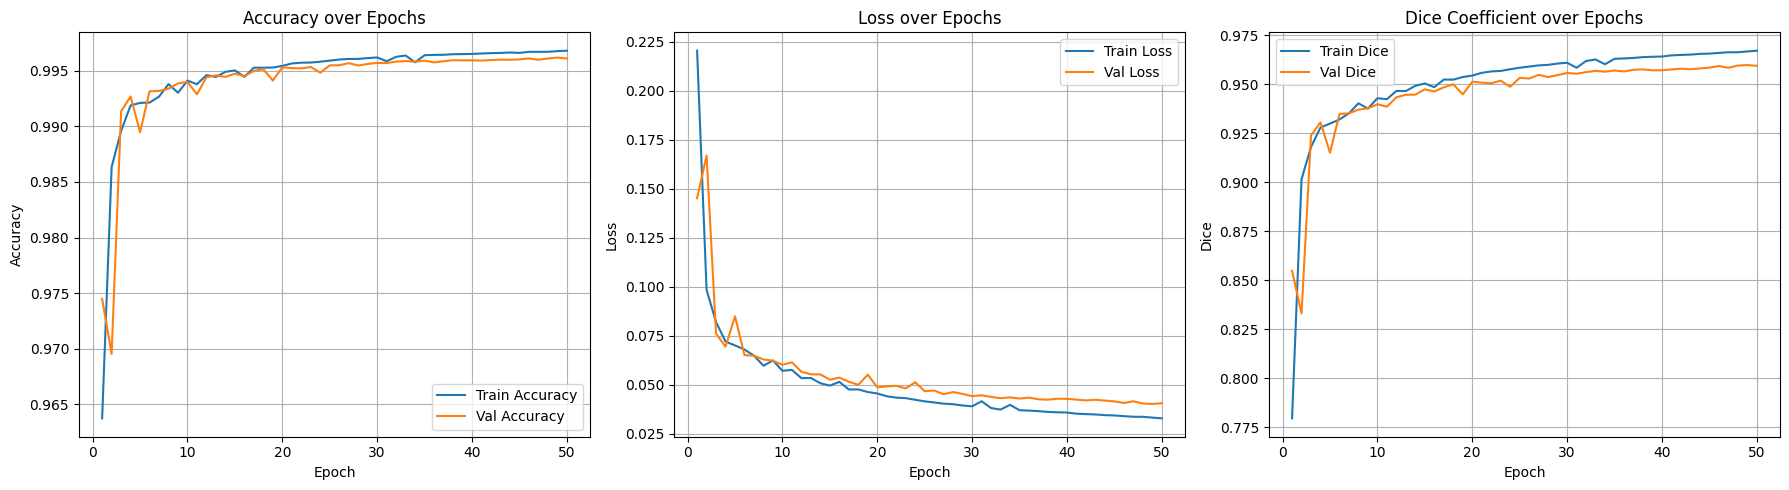

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(18, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Dice
plt.subplot(1, 3, 3)
plt.plot(epochs, history.history['dice_coefficient_multiclass'], label='Train Dice')
plt.plot(epochs, history.history['val_dice_coefficient_multiclass'], label='Val Dice')
plt.title("Dice Coefficient over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# ***Visual Comparison Code – Side-by-Side (Original, Ground Truth, Prediction, Overlay)***



In [ ]:
train_image_dir = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/Train/Images"
val_image_dir   = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/Validation/Images"

output_train_dir = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/Predicted_Labels/Train"
output_val_dir   = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/Predicted_Labels/Validation"

os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_val_dir, exist_ok=True)


In [ ]:
def resize_and_pad(arr, target_shape=(96, 128, 128)):
    result = np.zeros(target_shape, dtype=arr.dtype)
    z, y, x = arr.shape
    dz, dy, dx = target_shape

    z_start = max((z - dz) // 2, 0)
    y_start = max((y - dy) // 2, 0)
    x_start = max((x - dx) // 2, 0)

    z_end = min(z_start + dz, z)
    y_end = min(y_start + dy, y)
    x_end = min(x_start + dx, x)

    cropped = arr[z_start:z_end, y_start:y_end, x_start:x_end]

    tz = (dz - cropped.shape[0]) // 2
    ty = (dy - cropped.shape[1]) // 2
    tx = (dx - cropped.shape[2]) // 2

    result[tz:tz+cropped.shape[0], ty:ty+cropped.shape[1], tx:tx+cropped.shape[2]] = cropped
    return result


In [ ]:
def save_predictions(image_dir, output_dir):
    for filename in sorted(os.listdir(image_dir)):
        if not filename.endswith(".nii.gz"):
            continue

        img_path = os.path.join(image_dir, filename)
        img = nib.load(img_path).get_fdata()
        mean, std = np.mean(img), np.std(img)
        img = (img - mean) / std if std > 0 else np.zeros_like(img)

        # Resize if needed
        img = resize_and_pad(img, (96, 128, 128))
        input_tensor = np.expand_dims(img, axis=(0, -1))  # (1, 96, 128, 128, 1)

        pred = model.predict(input_tensor)[0]
        pred_label = np.argmax(pred, axis=-1)

        save_path = os.path.join(output_dir, filename.replace(".nii.gz", "_gt.nii.gz"))
        nib.save(nib.Nifti1Image(pred_label.astype(np.uint8), np.eye(4)), save_path)

        print(f"Saved: {save_path}")


In [ ]:
save_predictions(train_image_dir, output_train_dir)
save_predictions(val_image_dir, output_val_dir)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Saved: /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/Predicted_Labels/Train/patient001_frame01_gt.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Saved: /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/Predicted_Labels/Train/patient001_frame01_aug1_gt.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Saved: /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/Predicted_Labels/Train/patient001_frame01_aug2_gt.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Saved: /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/Predicted_Labels/Train/patient001_frame01_aug4_gt.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Saved: /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/Predicted_Labels/Train/patient001_frame01_aug5_gt.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Saved: /content/drive/MyDrive/ACDC dataset/S

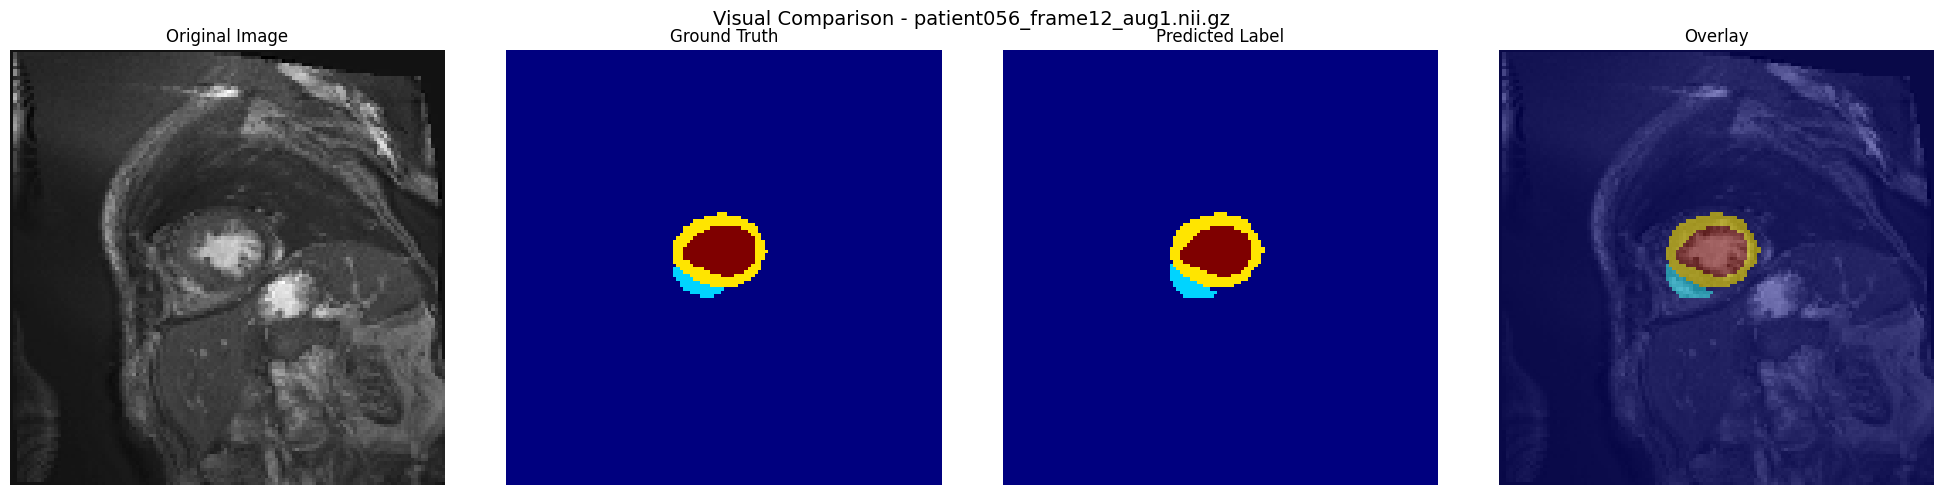

In [ ]:
import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Define paths
base_dir = "/content/drive/MyDrive/ACDC dataset/Segmentation"
image_dir = os.path.join(base_dir, "Training_Model", "Validation", "Images")
label_dir = os.path.join(base_dir, "Training_Model", "Validation", "Labels")
prediction_dir = os.path.join(base_dir, "Training_Model", "UNetPlusPlus_Light", "Predicted_Labels", "Validation")


available_preds = [f.replace("_gt.nii.gz", ".nii.gz") for f in os.listdir(prediction_dir)]
files = [f for f in os.listdir(image_dir) if f.endswith(".nii.gz") and f in available_preds]
filename = random.choice(files)

# Load data
img = nib.load(os.path.join(image_dir, filename)).get_fdata()
gt = nib.load(os.path.join(label_dir, filename.replace(".nii.gz", "_gt.nii.gz"))).get_fdata()
pred = nib.load(os.path.join(prediction_dir, filename.replace(".nii.gz", "_gt.nii.gz"))).get_fdata()

# Resize if necessary
def resize_and_pad(arr, target_shape=(96, 128, 128)):
    result = np.zeros(target_shape, dtype=arr.dtype)
    z, y, x = arr.shape
    dz, dy, dx = target_shape
    z_start = max((z - dz) // 2, 0)
    y_start = max((y - dy) // 2, 0)
    x_start = max((x - dx) // 2, 0)
    z_end = min(z_start + dz, z)
    y_end = min(y_start + dy, y)
    x_end = min(x_start + dx, x)
    cropped = arr[z_start:z_end, y_start:y_end, x_start:x_end]
    tz = (dz - cropped.shape[0]) // 2
    ty = (dy - cropped.shape[1]) // 2
    tx = (dx - cropped.shape[2]) // 2
    result[tz:tz+cropped.shape[0], ty:ty+cropped.shape[1], tx:tx+cropped.shape[2]] = cropped
    return result

target_shape = (96, 128, 128)
if img.shape != target_shape:
    img = resize_and_pad(img)
if gt.shape != target_shape:
    gt = resize_and_pad(gt)
if pred.shape != target_shape:
    pred = resize_and_pad(pred)

# Choose central slice
z = target_shape[0] // 2
img_slice = img[z]
gt_slice = gt[z]
pred_slice = pred[z]

# Plot
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle(f"Visual Comparison - {filename}", fontsize=14)

axs[0].imshow(img_slice, cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(gt_slice, cmap='jet')
axs[1].set_title("Ground Truth")
axs[1].axis('off')

axs[2].imshow(pred_slice, cmap='jet')
axs[2].set_title("Predicted Label")
axs[2].axis('off')

axs[3].imshow(img_slice, cmap='gray')
axs[3].imshow(pred_slice, cmap='jet', alpha=0.5)
axs[3].set_title("Overlay")
axs[3].axis('off')

plt.tight_layout()
plt.show()


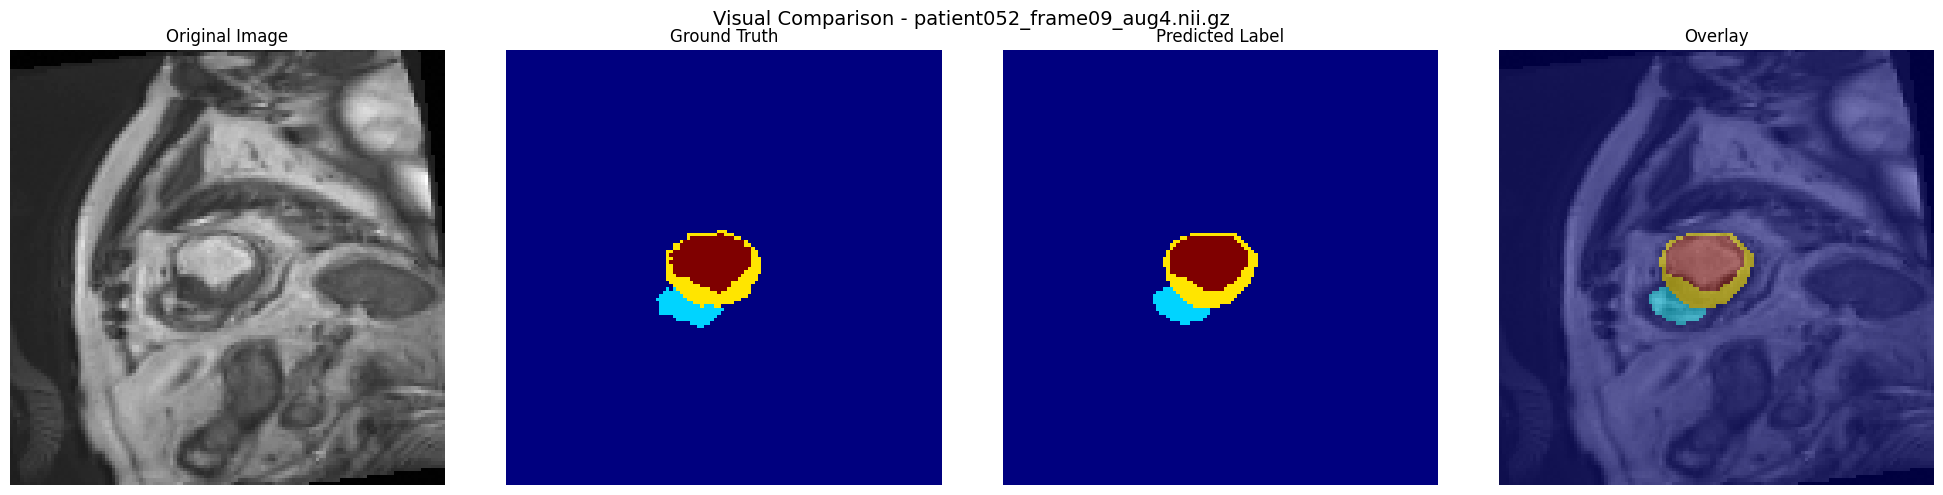

In [ ]:
import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Define paths
base_dir = "/content/drive/MyDrive/ACDC dataset/Segmentation"
image_dir = os.path.join(base_dir, "Training_Model", "Validation", "Images")
label_dir = os.path.join(base_dir, "Training_Model", "Validation", "Labels")
prediction_dir = os.path.join(base_dir, "Training_Model", "UNetPlusPlus_Light", "Predicted_Labels", "Validation")


available_preds = [f.replace("_gt.nii.gz", ".nii.gz") for f in os.listdir(prediction_dir)]
files = [f for f in os.listdir(image_dir) if f.endswith(".nii.gz") and f in available_preds]
filename = random.choice(files)

# Load data
img = nib.load(os.path.join(image_dir, filename)).get_fdata()
gt = nib.load(os.path.join(label_dir, filename.replace(".nii.gz", "_gt.nii.gz"))).get_fdata()
pred = nib.load(os.path.join(prediction_dir, filename.replace(".nii.gz", "_gt.nii.gz"))).get_fdata()

# Resize if necessary
def resize_and_pad(arr, target_shape=(96, 128, 128)):
    result = np.zeros(target_shape, dtype=arr.dtype)
    z, y, x = arr.shape
    dz, dy, dx = target_shape
    z_start = max((z - dz) // 2, 0)
    y_start = max((y - dy) // 2, 0)
    x_start = max((x - dx) // 2, 0)
    z_end = min(z_start + dz, z)
    y_end = min(y_start + dy, y)
    x_end = min(x_start + dx, x)
    cropped = arr[z_start:z_end, y_start:y_end, x_start:x_end]
    tz = (dz - cropped.shape[0]) // 2
    ty = (dy - cropped.shape[1]) // 2
    tx = (dx - cropped.shape[2]) // 2
    result[tz:tz+cropped.shape[0], ty:ty+cropped.shape[1], tx:tx+cropped.shape[2]] = cropped
    return result

target_shape = (96, 128, 128)
if img.shape != target_shape:
    img = resize_and_pad(img)
if gt.shape != target_shape:
    gt = resize_and_pad(gt)
if pred.shape != target_shape:
    pred = resize_and_pad(pred)

# Choose central slice
z = target_shape[0] // 2
img_slice = img[z]
gt_slice = gt[z]
pred_slice = pred[z]

# Plot
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle(f"Visual Comparison - {filename}", fontsize=14)

axs[0].imshow(img_slice, cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(gt_slice, cmap='jet')
axs[1].set_title("Ground Truth")
axs[1].axis('off')

axs[2].imshow(pred_slice, cmap='jet')
axs[2].set_title("Predicted Label")
axs[2].axis('off')

axs[3].imshow(img_slice, cmap='gray')
axs[3].imshow(pred_slice, cmap='jet', alpha=0.5)
axs[3].set_title("Overlay")
axs[3].axis('off')

plt.tight_layout()
plt.show()


# ***External Evaluation Using the ACDC Test Subset***



In [ ]:
import tensorflow as tf

model_path = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5"
model = tf.keras.models.load_model(model_path, compile=False)


In [ ]:
import os
import nibabel as nib
import numpy as np

# Test paths
input_dir = "/content/drive/MyDrive/ACDC dataset/testing/Normalized_Resampled_Images"
output_dir = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/Predicted_Labels/Testing"
os.makedirs(output_dir, exist_ok=True)

# Resize and pad
def resize_and_pad(arr, target_shape=(96, 128, 128)):
    result = np.zeros(target_shape, dtype=arr.dtype)
    z, y, x = arr.shape
    dz, dy, dx = target_shape
    z_start = max((z - dz) // 2, 0)
    y_start = max((y - dy) // 2, 0)
    x_start = max((x - dx) // 2, 0)
    z_end = min(z_start + dz, z)
    y_end = min(y_start + dy, y)
    x_end = min(x_start + dx, x)
    cropped = arr[z_start:z_end, y_start:y_end, x_start:x_end]
    tz = (dz - cropped.shape[0]) // 2
    ty = (dy - cropped.shape[1]) // 2
    tx = (dx - cropped.shape[2]) // 2
    result[tz:tz+cropped.shape[0], ty:ty+cropped.shape[1], tx:tx+cropped.shape[2]] = cropped
    return result

# Loop over all test patients
for fname in sorted(os.listdir(input_dir)):
    if not fname.endswith(".nii.gz"):
        continue

    img_path = os.path.join(input_dir, fname)
    img = nib.load(img_path).get_fdata()

    # Normalize
    mean, std = np.mean(img), np.std(img)
    img = (img - mean) / std if std > 0 else np.zeros_like(img)

    # Resize
    img = resize_and_pad(img, (96, 128, 128))
    input_tensor = np.expand_dims(img, axis=(0, -1))  # (1, 96, 128, 128, 1)

    # Predict
    pred = model.predict(input_tensor)[0]
    pred_label = np.argmax(pred, axis=-1)

    # Save result
    out_path = os.path.join(output_dir, fname.replace(".nii.gz", "_gt.nii.gz"))
    nib.save(nib.Nifti1Image(pred_label.astype(np.uint8), np.eye(4)), out_path)
    print(f" Saved: {fname} → {out_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
 Saved: patient101_frame01.nii.gz → /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/Predicted_Labels/Testing/patient101_frame01_gt.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
 Saved: patient101_frame14.nii.gz → /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/Predicted_Labels/Testing/patient101_frame14_gt.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
 Saved: patient102_frame01.nii.gz → /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/Predicted_Labels/Testing/patient102_frame01_gt.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
 Saved: patient102_frame13.nii.gz → /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/Predicted_Labels/Testing/patient102_frame13_gt.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
 Saved: patient103_frame01.nii.gz → /content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/P

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import nibabel as nib

# --- Custom dice coefficient and loss ---
import tensorflow.keras.backend as K

def dice_coefficient_multiclass(y_true, y_pred, smooth=1e-6):
    """
    Compute mean Dice coefficient across classes.
    Assumes y_true and y_pred are one-hot encoded with shape (batch, z, y, x, num_classes).
    """
    # sum over spatial dimensions for each class
    intersection = K.sum(y_true * y_pred, axis=[0,1,2,3])
    denominator  = K.sum(y_true + y_pred, axis=[0,1,2,3])
    dice_scores = (2. * intersection + smooth) / (denominator + smooth)
    return K.mean(dice_scores)

def dice_loss_multiclass(y_true, y_pred):
    """Dice loss = 1 - mean dice coefficient."""
    return 1.0 - dice_coefficient_multiclass(y_true, y_pred)

# --- Data generator for .nii.gz volumes ---
class NiiDataGenerator(Sequence):
    def __init__(self, image_dir, label_dir, batch_size=2, dim=(96,128,128), num_classes=4, shuffle=False):
        self.image_dir   = image_dir
        self.label_dir   = label_dir
        self.batch_size  = batch_size
        self.dim         = dim
        self.num_classes = num_classes
        self.shuffle     = shuffle
        self.files       = sorted([f for f in os.listdir(image_dir) if f.endswith(".nii.gz")])
        self.on_epoch_end()

    def __len__(self):
        # number of batches per epoch
        return len(self.files) // self.batch_size

    def __getitem__(self, idx):
        batch_files = self.files[idx*self.batch_size:(idx+1)*self.batch_size]
        X = np.zeros((self.batch_size, *self.dim, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.dim, self.num_classes), dtype=np.float32)
        for i, fname in enumerate(batch_files):
            # load image and label
            img = nib.load(os.path.join(self.image_dir, fname)).get_fdata()
            lbl = nib.load(os.path.join(self.label_dir, fname.replace(".nii.gz","_gt.nii.gz"))).get_fdata()
            # normalize image
            m, s = img.mean(), img.std()
            img  = (img - m)/s if s>0 else np.zeros_like(img)
            # fill arrays
            X[i,...,0] = img
            y[i]        = tf.one_hot(lbl.astype(np.uint8), depth=self.num_classes)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.files)

# --- Paths for test data ---
test_image_dir = "/content/drive/MyDrive/ACDC dataset/testing/Normalized_Resampled_Images"
test_label_dir = "/content/drive/MyDrive/ACDC dataset/testing/Resampled_Labels"

# --- Instantiate the test generator ---
test_gen = NiiDataGenerator(
    image_dir   = test_image_dir,
    label_dir   = test_label_dir,
    batch_size  = 2,
    dim         = (96,128,128),
    num_classes = 4,
    shuffle     = False
)

# --- Load the pre-trained model without compiling ---
model_path = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5"
model = tf.keras.models.load_model(model_path, compile=False)

# --- Compile with custom loss and metric ---
model.compile(
    optimizer = 'adam',
    loss      = dice_loss_multiclass,
    metrics   = ['accuracy', dice_coefficient_multiclass]
)

# --- Evaluate on the test set ---
test_loss, test_acc, test_dice = model.evaluate(test_gen, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 947ms/step - accuracy: 0.9944 - dice_coefficient_multiclass: 0.9457 - loss: 0.0543
Test Loss: 0.0563
Test Accuracy: 0.9938
Test Dice Coefficient: 0.9437


# ***Explaining the Segmentation Results using Grad-CAM (UNet++ Light 3D)***

Selected test file: patient121_frame01.nii.gz


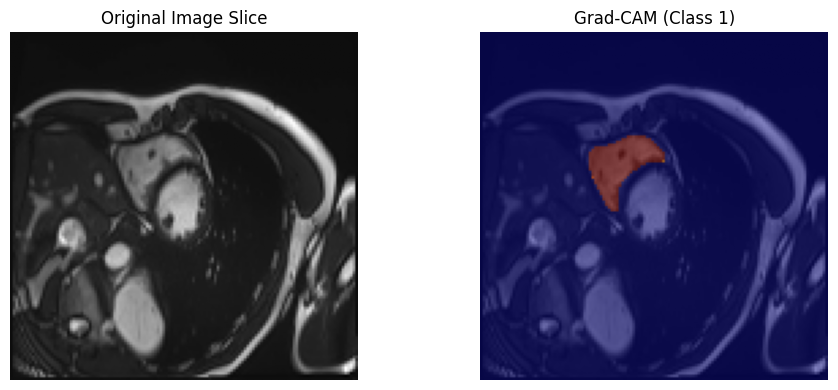

Model focused on class 1 (Right Ventricle) in this slice.


In [ ]:
import os
import random
import nibabel as nib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Paths ---
image_dir = "/content/drive/MyDrive/ACDC dataset/testing/Normalized_Resampled_Images"
model_path = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5"

# --- Resize and center the image to (96, 128, 128) ---
def resize_and_pad(arr, target_shape=(96, 128, 128)):
    result = np.zeros(target_shape, dtype=arr.dtype)
    z, y, x = arr.shape
    dz, dy, dx = target_shape
    z_start = max((z - dz) // 2, 0)
    y_start = max((y - dy) // 2, 0)
    x_start = max((x - dx) // 2, 0)
    z_end = min(z_start + dz, z)
    y_end = min(y_start + dy, y)
    x_end = min(x_start + dx, x)
    cropped = arr[z_start:z_end, y_start:y_end, x_start:x_end]
    tz = (dz - cropped.shape[0]) // 2
    ty = (dy - cropped.shape[1]) // 2
    tx = (dx - cropped.shape[2]) // 2
    result[tz:tz+cropped.shape[0], ty:ty+cropped.shape[1], tx:tx+cropped.shape[2]] = cropped
    return result

# --- Select a random 3D test image ---
all_files = [f for f in os.listdir(image_dir) if f.endswith(".nii.gz")]
chosen_file = random.choice(all_files)
print(f"Selected test file: {chosen_file}")

# --- Load and preprocess the image ---
image_path = os.path.join(image_dir, chosen_file)
image = nib.load(image_path).get_fdata()
image = resize_and_pad(image, (96, 128, 128))
image = (image - np.mean(image)) / np.std(image)
input_tensor = np.expand_dims(image, axis=(0, -1))  # shape: (1, 96, 128, 128, 1)

# --- Load the trained model ---
model = tf.keras.models.load_model(model_path, compile=False)

# --- Grad-CAM setup ---
last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
last_conv_layer = model.get_layer(last_conv_layer_name)

grad_model = tf.keras.models.Model(inputs=model.inputs,
                                   outputs=[last_conv_layer.output, model.output])

target_class = random.choice([1, 2, 3])  # skip background

# --- Compute Grad-CAM ---
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(input_tensor)
    loss = predictions[..., target_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()[0]
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap) + 1e-6

# --- Display mid-slice ---
z = heatmap.shape[0] // 2

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image Slice")
plt.imshow(image[z], cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM (Class {target_class})")
plt.imshow(image[z], cmap="gray")
plt.imshow(heatmap[z], cmap="jet", alpha=0.5)
plt.axis("off")
plt.tight_layout()
plt.show()

# --- Class name --- "Myocardium"  "Left Ventricle" "Right Ventricle"
class_names = {1: "Right Ventricle", 2: "Myocardium", 3: "Left Ventricle"}
print(f"Model focused on class {target_class} ({class_names.get(target_class, 'Unknown')}) in this slice.")


Selected test file: patient102_frame13.nii.gz


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 96, 128, 128, 1))
  warnings.warn(msg)


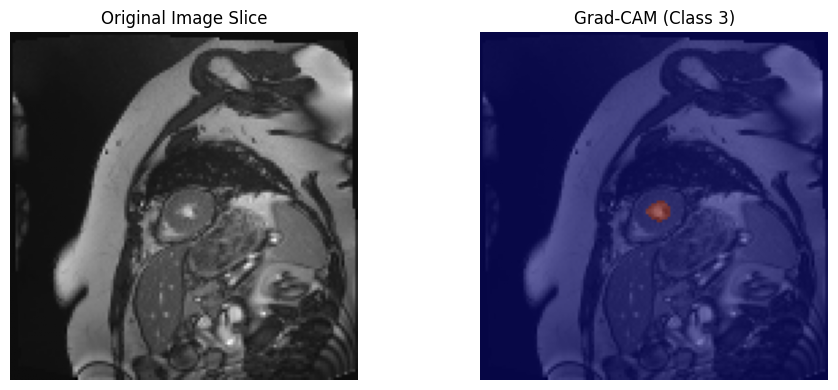

Model focused on class 3 (Left Ventricle) in this slice.


In [ ]:
import os
import random
import nibabel as nib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Paths ---
image_dir = "/content/drive/MyDrive/ACDC dataset/testing/Normalized_Resampled_Images"
model_path = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5"

# --- Resize and center the image to (96, 128, 128) ---
def resize_and_pad(arr, target_shape=(96, 128, 128)):
    result = np.zeros(target_shape, dtype=arr.dtype)
    z, y, x = arr.shape
    dz, dy, dx = target_shape
    z_start = max((z - dz) // 2, 0)
    y_start = max((y - dy) // 2, 0)
    x_start = max((x - dx) // 2, 0)
    z_end = min(z_start + dz, z)
    y_end = min(y_start + dy, y)
    x_end = min(x_start + dx, x)
    cropped = arr[z_start:z_end, y_start:y_end, x_start:x_end]
    tz = (dz - cropped.shape[0]) // 2
    ty = (dy - cropped.shape[1]) // 2
    tx = (dx - cropped.shape[2]) // 2
    result[tz:tz+cropped.shape[0], ty:ty+cropped.shape[1], tx:tx+cropped.shape[2]] = cropped
    return result

# --- Select a random 3D test image ---
all_files = [f for f in os.listdir(image_dir) if f.endswith(".nii.gz")]
chosen_file = random.choice(all_files)
print(f"Selected test file: {chosen_file}")

# --- Load and preprocess the image ---
image_path = os.path.join(image_dir, chosen_file)
image = nib.load(image_path).get_fdata()
image = resize_and_pad(image, (96, 128, 128))
image = (image - np.mean(image)) / np.std(image)
input_tensor = np.expand_dims(image, axis=(0, -1))  # shape: (1, 96, 128, 128, 1)

# --- Load the trained model ---
model = tf.keras.models.load_model(model_path, compile=False)

# --- Grad-CAM setup ---
last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
last_conv_layer = model.get_layer(last_conv_layer_name)

grad_model = tf.keras.models.Model(inputs=model.inputs,
                                   outputs=[last_conv_layer.output, model.output])

target_class = random.choice([1, 2, 3])  # skip background

# --- Compute Grad-CAM ---
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(input_tensor)
    loss = predictions[..., target_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()[0]
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap) + 1e-6

# --- Display mid-slice ---
z = heatmap.shape[0] // 2

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image Slice")
plt.imshow(image[z], cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM (Class {target_class})")
plt.imshow(image[z], cmap="gray")
plt.imshow(heatmap[z], cmap="jet", alpha=0.5)
plt.axis("off")
plt.tight_layout()
plt.show()

# --- Class name --- "Myocardium"  "Left Ventricle" "Right Ventricle"
class_names = {1: "Right Ventricle", 2: "Myocardium", 3: "Left Ventricle"}
print(f"Model focused on class {target_class} ({class_names.get(target_class, 'Unknown')}) in this slice.")


Selected test file: patient108_frame01.nii.gz


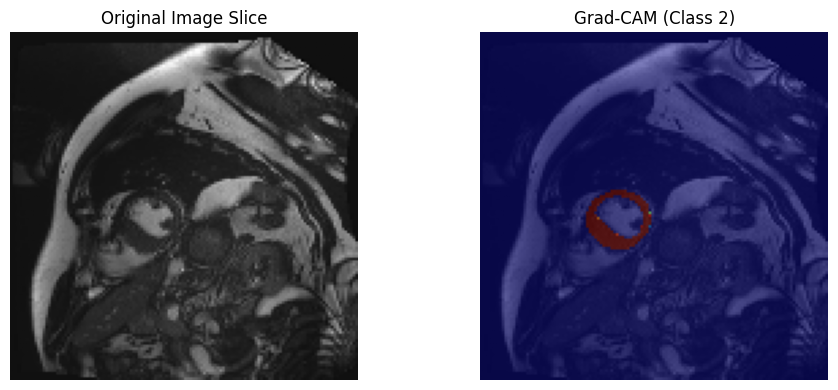

Model focused on class 2 (Myocardium) in this slice.


In [ ]:
import os
import random
import nibabel as nib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Paths ---
image_dir = "/content/drive/MyDrive/ACDC dataset/testing/Normalized_Resampled_Images"
model_path = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model/UNetPlusPlus_Light/best_model.h5"

# --- Resize and center the image to (96, 128, 128) ---
def resize_and_pad(arr, target_shape=(96, 128, 128)):
    result = np.zeros(target_shape, dtype=arr.dtype)
    z, y, x = arr.shape
    dz, dy, dx = target_shape
    z_start = max((z - dz) // 2, 0)
    y_start = max((y - dy) // 2, 0)
    x_start = max((x - dx) // 2, 0)
    z_end = min(z_start + dz, z)
    y_end = min(y_start + dy, y)
    x_end = min(x_start + dx, x)
    cropped = arr[z_start:z_end, y_start:y_end, x_start:x_end]
    tz = (dz - cropped.shape[0]) // 2
    ty = (dy - cropped.shape[1]) // 2
    tx = (dx - cropped.shape[2]) // 2
    result[tz:tz+cropped.shape[0], ty:ty+cropped.shape[1], tx:tx+cropped.shape[2]] = cropped
    return result

# --- Select a random 3D test image ---
all_files = [f for f in os.listdir(image_dir) if f.endswith(".nii.gz")]
chosen_file = random.choice(all_files)
print(f"Selected test file: {chosen_file}")

# --- Load and preprocess the image ---
image_path = os.path.join(image_dir, chosen_file)
image = nib.load(image_path).get_fdata()
image = resize_and_pad(image, (96, 128, 128))
image = (image - np.mean(image)) / np.std(image)
input_tensor = np.expand_dims(image, axis=(0, -1))  # shape: (1, 96, 128, 128, 1)

# --- Load the trained model ---
model = tf.keras.models.load_model(model_path, compile=False)

# --- Grad-CAM setup ---
last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
last_conv_layer = model.get_layer(last_conv_layer_name)

grad_model = tf.keras.models.Model(inputs=model.inputs,
                                   outputs=[last_conv_layer.output, model.output])

target_class = random.choice([1, 2, 3])  # skip background

# --- Compute Grad-CAM ---
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(input_tensor)
    loss = predictions[..., target_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()[0]
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap) + 1e-6

# --- Display mid-slice ---
z = heatmap.shape[0] // 2

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image Slice")
plt.imshow(image[z], cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM (Class {target_class})")
plt.imshow(image[z], cmap="gray")
plt.imshow(heatmap[z], cmap="jet", alpha=0.5)
plt.axis("off")
plt.tight_layout()
plt.show()

# --- Class name --- "Myocardium"  "Left Ventricle" "Right Ventricle"
class_names = {1: "Right Ventricle", 2: "Myocardium", 3: "Left Ventricle"}
print(f"Model focused on class {target_class} ({class_names.get(target_class, 'Unknown')}) in this slice.")
